## Avaliação em holdouts - Amazon Kindle

Interactions in the 'Amazon Kindle' dataset are SOMEWHAT well distributed.
Several users are present during the whole considered period (2014):
<!-- * 37067 users of 190248 (19.484%) occurr in 80.0% or more months. -->
* 3385 users of 5849 (57.873%) occurr in 80.0% or more months.

In [1]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

In [2]:
from data import ImplicitData, getBucketsHoldouts
from plot_utils import lineplot_recallxholdout, recall_heatmap
from dataset_evaluation_utils import *
from recommenders_implicit import ISGD, RAISGD, RSISGD  # ISGD framework, BISGD,
from eval_implicit import EvaluateHoldouts, EvaluateAndStore, EvalPrequential # EvaluateAndStore para guardar estados do modelo e holdouts, a avaliação prequencial de ratings implicitos é opcional, , EvalHoldout

from datetime import datetime
import joblib
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

___
## BWT FWT

ACC, BWT, e FWT - Lopez-Paz e Ranzato GEM

In [3]:
def avg_recall(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    return np.mean( np.diag(results_matrix) )

def compute_BWT(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    BWT = []
    n_checkpoints = results_matrix.shape[0]
    for T in range(1, n_checkpoints): # 1 means holdout 2, 2 means 3, so on
        Rti = results_matrix.iloc[T, 0:T] # get models performances' on previous holdouts
        Rii = np.diag(results_matrix)[0:T] # get models performances' on their closest holdouts (diagonal)
        E = sum( Rti - Rii ) # future models performances' - performances' of models closest to holdouts (diagonal)
        BWT.append( E/T ) # store average BWT for model
    return BWT, np.mean( BWT ) # return BWT and average BWT for all models

def compute_FWT(results_matrix): # Díaz-Rodriguez et al. 2018
    upper_tri = results_matrix.to_numpy()[np.triu_indices(results_matrix.shape[0], k=1)]
    return np.mean(upper_tri)

___
# Amazon Kindle
Small subset, ratings only.  
https://nijianmo.github.io/amazon/index.html


In [4]:
# importa dataset 'books playlists'
data = pd.read_csv('output/amazonkindle_dump/2nd_sampled_amazon_kindle.csv')
dataset_name = 'Amazon_Kindle'
user_col = 'user_id'
item_col = 'item_id'

In [5]:
data.shape

(88823, 4)

In [6]:
data.head()

,user_id,item_id,timestamp,date
0,B006CRHK62,A3C30AHYCUVOPC,1388534400,2014-01-01
1,B006PVGZ0W,A2LQ5WX7S9XCPI,1388534400,2014-01-01
2,B00H3HITIS,A3LB84BRSZVALZ,1388534400,2014-01-01
3,B00E4T0P3U,A3TJOBVQ95HK9Z,1388534400,2014-01-01
4,B0068XJXJC,A1OZAIZZVOFOZR,1388534400,2014-01-01


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88823 entries, 0 to 88822
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    88823 non-null  object
 1   item_id    88823 non-null  object
 2   timestamp  88823 non-null  int64 
 3   date       88823 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.7+ MB


### Convert timestamp

In [8]:
%%time 
# 2.42s
data['date'] = data['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
# data.sort_values(by='timestamp', inplace=True)

CPU times: user 817 ms, sys: 13.3 ms, total: 830 ms
Wall time: 829 ms


In [9]:
data.head()

,user_id,item_id,timestamp,date
0,B006CRHK62,A3C30AHYCUVOPC,1388534400,2014-01-01
1,B006PVGZ0W,A2LQ5WX7S9XCPI,1388534400,2014-01-01
2,B00H3HITIS,A3LB84BRSZVALZ,1388534400,2014-01-01
3,B00E4T0P3U,A3TJOBVQ95HK9Z,1388534400,2014-01-01
4,B0068XJXJC,A1OZAIZZVOFOZR,1388534400,2014-01-01


CPU times: user 82.3 ms, sys: 9.36 ms, total: 91.6 ms
Wall time: 90.8 ms


Text(0.5, 1.0, 'interactions per month')

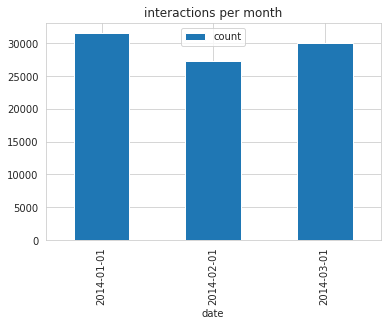

In [10]:
%%time
# 198ms
interactions_per_month = data.groupby(by=['date']).count().iloc[:, 0]
interactions_per_month.name = 'count'
interactions_per_month=interactions_per_month.reset_index()
_ = interactions_per_month.copy()
_['date'] = _['date'].dt.date
_.groupby('date').sum().plot(kind='bar')
plt.title('interactions per month')

___
## Get intervals and Frequent users (threshold = 0.8)

time intervals

In [38]:
user_presence_df = pd.read_csv('output/amazonkindle_dump/2nd_sample_user_presence_df.csv')
user_month_interactions = pd.read_csv('output/amazonkindle_dump/2nd_sample_user_month_interactions.csv')
frequent_users_month = joblib.load('output/amazonkindle_dump/2nd_sample_frequent_users_month.joblib')

___
## Experiments using months

In [39]:
data.shape

(88823, 4)

In [40]:
%%time
# 1min 48s
buckets, holdouts = getBucketsHoldouts(
    data=data,
    user_col=user_col,
    item_col=item_col,
    frequent_users=frequent_users_month, # for every user in holdout: data['user_id'].unique()
    interval_type='M',
    intervals=None, 
    cold_start_buckets=0)

Creating buckets. . .
Creating holdouts. . .
Cleaning holdouts. . .
common interactions between bucket 1 and all holdouts.
25
common interactions between bucket 2 and all holdouts.
26
common interactions between bucket 3 and all holdouts.
31
Converting to ImplicitData. . .
Done!
CPU times: user 1min 14s, sys: 0 ns, total: 1min 14s
Wall time: 1min 14s


Debugging buckets and holdouts - **only works if they're not converted to implicit data in get_buckets_and_holdouts.getBucketsHoldouts**

In [59]:
sum( [b.size for b in buckets] ) + sum( [h.size for h in holdouts] )

88823

In [42]:
# # join buckets and holdouts, to check if they have any equal interactions (they should not)
# a = pd.concat( buckets ).set_index([user_col, item_col])
# b = pd.concat( holdouts )[[user_col, item_col]].set_index([user_col, item_col])
# a.join(b, how='inner').shape[0]

In [43]:
# # concatenate buckets and holdouts, to check if the result is equal to the original data (it should be equal)
# _  = pd.concat( [pd.concat( buckets ), pd.concat( holdouts )], ignore_index=True).sort_values(by=['timestamp', 'user_id','item_id']).reset_index(drop=True)
# _.equals(data.sort_values(by=['timestamp', 'user_id','item_id']).reset_index(drop=True))

In [16]:
# bucket_sizes = [b.shape[0] for b in buckets]
# holdout_sizes = [h.shape[0] for h in holdouts]
# bucket_sizes, holdout_sizes

In [60]:
joblib.dump(buckets, 'output/amazonkindle_dump/2nd_sample_buckets.joblib')
joblib.dump(holdouts, 'output/amazonkindle_dump/2nd_sample_holdouts.joblib')

['output/amazonkindle_dump/2nd_sample_holdouts.joblib']

### ISGD

In [53]:
buckets = joblib.load('output/amazonkindle_dump/2nd_sample_buckets.joblib')
holdouts = joblib.load('output/amazonkindle_dump/2nd_sample_holdouts.joblib')

Hyperparameters

In [35]:
import itertools
def grid_search(model, stream, random_seed = 10, interleaved=10):    
    num_factors = [100, 150, 200]
    num_iter = [2, 5, 8]
    learn_rate = [0.1, 0.25, 0.5]
    regularization = [0.3, 0.4, 0.5]
    num_nodes = [4, 8, 16]
    grid = [num_factors, num_iter, learn_rate, regularization, num_nodes]
    grid = list(itertools.product(*grid))
    results = []
    for i, hp in enumerate(grid):
        if not ((i*100)/len(grid))%5:
            print(((i*100)/len(grid)), '%')
        empty_stream = ImplicitData([], [])
        nf, ni, lr, reg, nn = hp
        m = model(empty_stream, nf, ni, lr, reg, reg, random_seed)
        e = EvalPrequential(m, stream, metrics = ["Recall@20"])
        result = e.Evaluate(start_eval=0, count=stream.size, interleaved=interleaved)
        results.append( np.mean(result['Recall@20']) )
    return grid, results    

# OPTIONAL FOR NOW
prop = 0.1
hp_sample = data.iloc[:round( data.shape[0]*prop )]
stream = ImplicitData(hp_sample[user_col], hp_sample[item_col]) #(data['playlist_id'],data['track_id'])    
grid, results = grid_search(model=ISGD, stream=stream, random_seed=10, interleaved=1 )
len(grid), len(results), max(results)

In [32]:
# define hyperparameters (SAME AS LASTFM) ????
num_factors = 160
num_iter = 4
learn_rate = 0.5
regularization = 0.4
num_nodes = 8

In [44]:
# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte. recebe listas
# stream = ImplicitData(data[user_col], data[item_col])
# O modelo deve ser iniciado com uma lista vazia
empty_stream = ImplicitData([], [])
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [45]:
%%time
# 23min 39s
# criamos instancia de EvaluateHoldouts para treinar o modelo e criar checkpoints
eval = EvaluateHoldouts(model=model, buckets=buckets, holdouts=holdouts)

bucket 0
bucket 1
bucket 2
CPU times: user 16min 47s, sys: 0 ns, total: 16min 47s
Wall time: 16min 47s


In [46]:
%%time
# 1h 12min 53s
eval.EvaluateHoldouts(N_recommendations=20, exclude_known_items=True, default_user='none')

Holdout 0
Model 0
recommendations not made for users in holdout 0 x bucket 0: 24
Model 1
recommendations not made for users in holdout 0 x bucket 1: 18
Model 2
recommendations not made for users in holdout 0 x bucket 2: 16
Holdout 1
Model 0
recommendations not made for users in holdout 1 x bucket 0: 1131
Model 1
recommendations not made for users in holdout 1 x bucket 1: 11
Model 2
recommendations not made for users in holdout 1 x bucket 2: 9
Holdout 2
Model 0
recommendations not made for users in holdout 2 x bucket 0: 2095
Model 1
recommendations not made for users in holdout 2 x bucket 1: 909
Model 2
recommendations not made for users in holdout 2 x bucket 2: 20
CPU times: user 6h 10min 54s, sys: 10h 59min 4s, total: 17h 9min 59s
Wall time: 1h 17min 49s


In [49]:
#0.0 freq T
rm = eval.results_matrix
df = pd.DataFrame(rm.T)
df.to_csv('output/amazonkindle_dump/2nd_sample_amazon_kindle month_bucket ISGD results.csv', index=False)

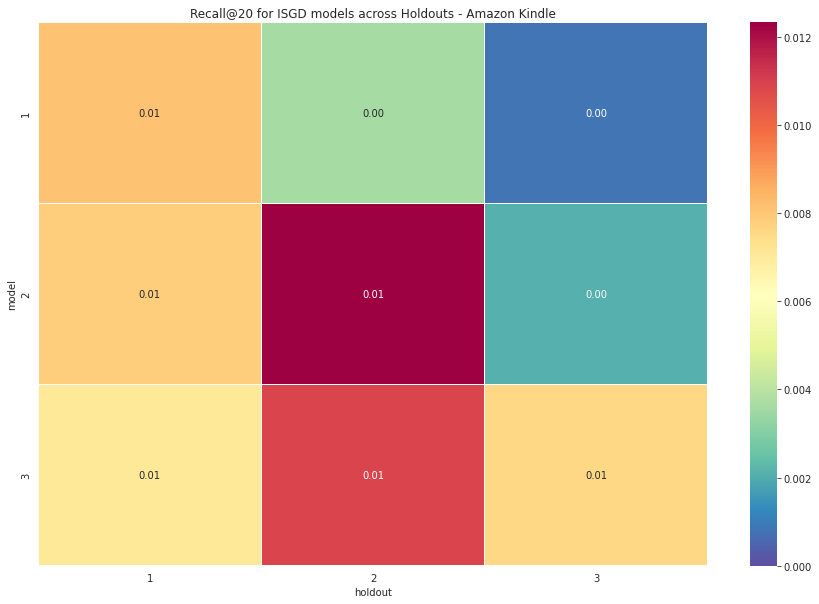

In [51]:
recall_heatmap(df,
    title='Recall@20 for ISGD models across Holdouts - Amazon Kindle',
    filepath='images/heatmaps/amazonkindle_dump/2nd_sample_amazon_kindle month_bucket ISGD heatmap.png') #='images/heatmaps/palco_2010 month_bucket ISGD heatmap.png'

In [54]:
arecall = avg_recall(df)
arecall

0.00935281104595877

In [55]:
BWT, meanBWT = compute_BWT(df)
BWT, meanBWT

([-0.00027417094096083075, -0.0012409358828889415], -0.0007575534119248861)

In [56]:
FWT = compute_FWT(df)
FWT
# que itens que usuario utilizou no passado e deixou de consumir o sistema ainda pode recomendar

0.002199127608080812

In [58]:
joblib.dump(eval.IncrementalTraining_time_record, 'output/amazonkindle_dump/2nd_sample_amazon_kindle month_bucket ISGD training time.joblib')
joblib.dump(eval.EvaluateHoldouts_time_record, 'output/amazonkindle_dump/2nd_sample_amazon_kindle month_bucket ISGD eval time.joblib')

['output/amazonkindle_dump/2nd_sample_amazon_kindle month_bucket ISGD eval time.joblib']